In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter

%matplotlib inline

#Load files, so far the format has to be specific
df1 = pd.read_csv("../data/malla.csv", sep=';')
df2 = pd.read_csv("../data/explosivo.csv", sep=';')

#Fill NaN values
df1.fillna(0,inplace=True)
df2.fillna(0, inplace=True)

#Joins dataframes
blast = df1.join(df2, how='left')

display(df1)
display(df2)

,project,dens_ore,d_hole,burden,spacing,h_hole,s_drilling,stem,h_ bench,blast_width,blast_lenght,interhole_time,std_init_sys,P_wave,UCS,young_mod,n_holes,ccl,m_material
0,malla_1,2.55,270,7.5,8.5,15,2,5.5,15,40,35.0,25,0.5,5,110,45,0.0,0.0,0.0
1,malla_2,2.55,311,9.1,10.5,15,2,7.0,15,40,41.5,15,0.2,4,150,50,0.0,0.0,0.0
2,malla_3,2.55,220,8.0,9.0,10,2,4.5,10,40,32.0,20,1.0,6,95,35,0.0,0.0,0.0


,expl,dens_expl,rws,vod,expl_x_hole,powder_f,energ_f,t_det_pres
0,expl_1,1.3,130,5000,0.0,0.0,0.0,0.0
1,expl_2,1.3,120,4000,0.0,0.0,0.0,0.0
2,expl_3,1.0,115,3000,0.0,0.0,0.0,0.0


In [10]:
#Calculates the A_factor (rock factor)
#blast['A_factor'] = [6,7,3]

#RMD to develop
'''if rock = powdery-friable:
    RMD = 10

elif rock = massive:
    RMD = 50

elif rock = vertically_jointed:
    if joint = tight_joins:
        JCF = 1
    elif joint = relaxed_joints:
        JCF = 1.5
    elif joint = filled_joints:
        JCF = 2

    elif joint_spacing < 0.1:
        JPS = 10
    elif 0.1 < joint_spacing < 0.3:
        JPS = 20
    elif joint_spacing > np.sqrt(B * S):
        JPS = 50

    if joints = dip_out_face:
        JPA = 40
    elif joints = strike_out_face:
        JPA = 30
    elif joints = dip_into_face:
        JPA = 20

    JF = ( JCF * JPS) + JPA
    RMD = JF
'''

#Adds drilling deviation values for each of the blasts
blast['drilling_dev'] = [0.5,0.5,0.5]

# Columns to check or columns you want to add that implies a formula
#Añadir y corregir At
columns_to_check = ['n_holes', 'ccl', 'm_material', 'expl_x_hole', 't_det_pres', 'powder_f', 'energ_f','A_factor','At','X50','n_c','P80']

# Initialize these columns with NaN if they don't exist:
    #basically adds a new column (if you want) and then you could define an equation for that column and keep adding values (or not)
for col in columns_to_check:
    if col not in blast.columns:
        blast[col] = np.nan

# Equations to calculate cells values
def calculate_values(row):
    
    '''- Number of Boreholes
    - Column Charge Lenght - ccl (m)
    - Moved Material (ton)
    - Kg of explosive per hole
    - Powder Factor (kg/m3)
    - Energy Factor
    - Theoretical Detonation Pressure (GPa)
    - Rock Factor A
    - Delay Factor At
    - Medium Size of Fragments X50 (mm)
    - Uniformity index (coarse)
    - P80'''

    row['n_holes'] = round((row["blast_lenght"] / row["burden"]) * (row["blast_width"] / row["spacing"]))
    row['ccl'] = round(row["h_hole"] + row["s_drilling"] - row["stem"], 1)
    row['m_material'] = round(row["h_hole"] * row["burden"] * row["spacing"] * row["dens_ore"], 1)
    row['expl_x_hole'] = round(np.pi * ((row['d_hole'] / 1000)**2) * (row['ccl'] / 4) * (row['dens_expl'] * 1000), 1)
    row['t_det_pres'] = round(0.25 * row["dens_expl"] * (row["vod"]**2) * (10**-6), 2)
    row['powder_f'] = round(row['dens_ore'] * row['expl_x_hole'] / row['m_material'], 2)
    row['energ_f'] = round(row['rws'] * row['powder_f'], 1)

    #Add delay factor At based on interow timing and standard deviation of the initiation system
    #interhole_time;P_wave

    t = row['interhole_time']/((15.6/row['P_wave'])*row['burden'])

    if t < 1 and t > 0:
        row['At'] = round(0.66 * (t**3) - 0.13 * (t**2) - 1.58 * t + 2.1, 2)
    else:
        row['At'] = round(0.9 + 0.1 * (t-1), 2)

    #Add precision factor ns
    #std_init_sys

    ns = 0.206 + (1 - (6 * (row['std_init_sys']/row['interhole_time'])/4))**0.8

#############################################################################################
    #RMD provisional
    RMD = 50 #We assume it is massive but we can manually change it if we desire,
    #Powdery/Friable ==> RMD = 10
    #Vertically Jointed ==> Has to be calculated based on JPS, JPA and JCF.

    #Rock Density Influece
    RDI = 25 * row['dens_ore'] - 50

    #Hardness Factor
    if row['young_mod'] < 50:
        HF = row['young_mod'] / 3

    else:
        HF = row['UCS'] / 5

    row['A_factor'] = 0.06 * (RMD + RDI + HF) * 1 #C(A) correction factor 0.5 - 2
#############################################################################################

    #Add X50 (mm) and uniformity index (n coarse) for each blast design
    row['X50'] = round(row['At'] * row['A_factor'] * (row['powder_f']**-0.8) * (row['expl_x_hole']**0.167) * ((115/row['rws'])**0.633) * 10) # x10 is conversion cm to mm
    row['n_c'] = round(((row['A_factor']/6)**0.3) * ns * ((2-30*row['burden']/row['d_hole'])**0.5) * (((1 + (row['spacing']/row['burden']))/2)**0.5)
                        * (1 - (row['drilling_dev']/row['burden'])) * (((row['h_hole']-row['stem'])/row['h_hole'])**0.3) * 1, 2)#C(n) correction
    row['P80'] = round(row['X50']*(((np.log(0.2)/-0.693)**(1/row['n_c']))))

    return row

# While Loop to keep processing until there are no more NaN or 0 on the fixed columns
while blast[columns_to_check].isnull().values.any() or (blast[columns_to_check] == 0).values.any():
    for ind, row in blast.iterrows():
        
        #If any of the mentioned columns are NaN or 0 it recalculates
        if row[columns_to_check].isnull().any() or (row[columns_to_check] == 0).any():
            blast.loc[ind] = calculate_values(row)

# Show results
display(blast)

,project,dens_ore,d_hole,burden,spacing,h_hole,s_drilling,stem,h_ bench,blast_width,...,expl_x_hole,powder_f,energ_f,t_det_pres,drilling_dev,A_factor,At,X50,n_c,P80
0,malla_1,2.55,270,7.5,8.5,15,2,5.5,15,40,...,856.0,0.90,117.0,8.12,0.5,4.725,0.91,134.0,1.00,311.0
1,malla_2,2.55,311,9.1,10.5,15,2,7.0,15,40,...,987.5,0.69,82.8,5.20,0.5,5.625,1.46,340.0,1.00,790.0
2,malla_3,2.55,220,8.0,9.0,10,2,4.5,10,40,...,285.1,0.40,46.0,2.25,0.5,4.525,1.05,254.0,0.81,719.0


,project,expl,X50,P80
0,malla_1,expl_1,134.0,311.0
1,malla_2,expl_2,340.0,790.0
2,malla_3,expl_3,254.0,719.0


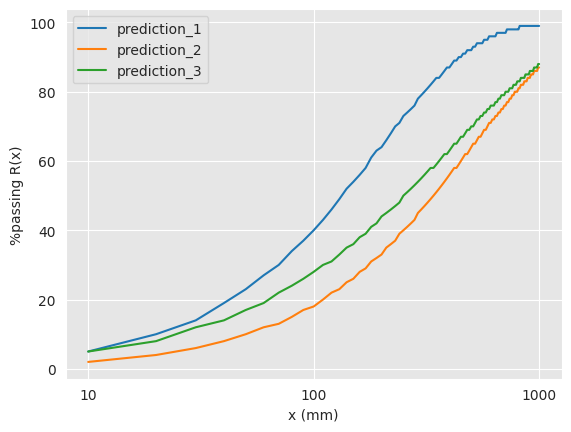

In [11]:
#Empty lists for %passing values
Px = []
Px1 = []
Px2 = []

#Tamaño de tamiz
x = list(range(10,1001,10))

#Variables from dataset for R(x) equation
X501 = blast.iloc[0,-3]
X502 = blast.iloc[1,-3]
X503 = blast.iloc[2,-3]
n1 = blast.iloc[0,-2]
n2 = blast.iloc[1,-2]
n3 = blast.iloc[2,-2]

#Obtaining different values
for i in x:
    h = round(100 * (1 - math.exp(-0.693 * (i/X501)**n1)))
    Px.append(h)

    h1 = round(100 * (1 - math.exp(-0.693 * (i/X502)**n2)))
    Px1.append(h1)
    
    h2 = round(100 * (1 - math.exp(-0.693 * (i/X503)**n3)))
    Px2.append(h2)

#Resume table
blast_summary = blast.iloc[[0,1,2],[0,-14,-3,-1]]
display(blast_summary)

#Plotting

sns.set_style("darkgrid", {"axes.facecolor": ".9"})

fig, ax = plt.subplots()

ax.plot(x,Px, label = 'prediction_1')
ax.plot(x,Px1, label = 'prediction_2')
ax.plot(x,Px2, label = 'prediction_3')

plt.yticks(np.arange(0,120,step=20))

plt.xscale("log")
ax.xaxis.set_major_formatter(ScalarFormatter())

ax.set_xlabel('x (mm)')
ax.set_ylabel('%passing R(x)')

ax.legend()
plt.show()

In [12]:
test_fines = blast.loc[:,('burden', 'spacing', 'h_hole', 'dens_ore', 'dens_expl', 'vod', 'd_hole', 'P_wave', 'X50',  'young_mod',  'UCS')]
test_fines['Ts'] = [6000000,7000000,8000000] #Pascales tensile strength
test_fines['v'] = [0.24,0.24,0.24] #Poisson
display(test_fines)

,burden,spacing,h_hole,dens_ore,dens_expl,vod,d_hole,P_wave,X50,young_mod,UCS,Ts,v
0,7.5,8.5,15,2.55,1.3,5000,270,5,134.0,45,110,6000000,0.24
1,9.1,10.5,15,2.55,1.3,4000,311,4,340.0,50,150,7000000,0.24
2,8.0,9.0,10,2.55,1.0,3000,220,6,254.0,35,95,8000000,0.24


#Calculo uniformity index fines
 
- rc(mm) radius crushed zone
- ro(mm)borehole radius == d_hole (mm)/2
- CZI Crushed Zone Index
- Pb (Pa) borehole pressure
- k => rock stiffness factor
- sigma c(Pa) == UCS (MPa)
- dens0 (kg/m3) == dens_expl (gr/cm3)
- VOD (m/s) == vod (m/s)
- Ed (Pa) dynamic yound modulus
- v = Poisson ratio
- Est (GPa) static Young == young_mod (GPa)
- rock density (gr/cm3) density == dens_ore (gr/cc)(ton/m3)

- Es = borehole stress
- Td (Pa) == dynamic tensile strength (4-8 times static value)
- rock density for Vb == dens_ore * 1000 (kgm/3)
- Vp (m/s) == P_wave (m/ms) *1000
- Gamma == adiabatic exponent of detonation products:: 0.655(dens_expl) + 0.702 + 1.107(dens_expl) :: 1.819 - (0.196/dens_expl) + 0.712(dens_expl)
- Ts (Pa) == static tensile strength --- se tiene que añadir en Pascales -- junto con UCS y Young
ro (m)
- rc (m)
- phi == pressure decay factor (-1.24 to -1.65)
- Peq (Pa) == equilibrum pressure
- Ed (GPa)

- C = crack number
- C1 = crack length/maximum crack extension (m)

In [13]:
# Equations to calculate cells values
def calculate_fines(row):

    #Crushed Zone Volume (Vc)
    Ed = (10**((np.log10(row['young_mod'])-0.02)/0.77))/row['dens_ore']
    k = (Ed*10**9)/(1+row['v'])
    Pb = (((row['dens_expl']*1000) * (row['vod']**2))/4)/2
    CZI = (Pb**3)/(k*(((row['UCS']*10**6)**2)))
    rc = 0.812 * (CZI**0.219) * row['d_hole']/2
    
    #Cracked Zone Volume (Vb)
    phi = -(0.0085 * Ed + 0.9955) * (row['P_wave'] * 1000/row['vod'])**-0.33
    Peq = Pb * ((rc/(row['d_hole']/2))**phi)
    Gamma = 1.819 - (0.196/row['dens_expl']) + 0.712 * row['dens_expl']
    Es = ((1 - row['v']) * Pb)/((2 * (1 - 2 * row['v']) * row['dens_ore']*1000 * ((row['P_wave']*1000)**2)) + (3 * (1 - row['v']) * Gamma * Pb))


    #Ts (Pa) == static tensile strength --- se tiene que añadir en Pascales -- junto con UCS y Young
    C = math.ceil(Es * (Pb/(6 * row['Ts'])))
    C1 = ((row['d_hole']/2)/1000) * ((row['Ts']/Peq)**(1/phi)) - (rc/1000)

    ######################################## has to be reviewed ##############################################################
    Vc = np.pi * ((rc/1000)**2) * row['h_hole']

    Vb = C * ((row['h_hole'] * ((row['d_hole']/2)/1000) * C1) / 2)

    Vt = row['burden'] * row['spacing'] * row['h_hole']

    #Fines inflexion point
    fc = (Vc + Vb)/Vt

    nf = round(np.log(np.log(1-fc)/-0.693)/np.log(1/row['X50']), 2)

    return nf

# Show results
test_fines['n_f'] = test_fines.apply(calculate_fines, axis=1)
display(test_fines)

,burden,spacing,h_hole,dens_ore,dens_expl,vod,d_hole,P_wave,X50,young_mod,UCS,Ts,v,n_f
0,7.5,8.5,15,2.55,1.3,5000,270,5,134.0,45,110,6000000,0.24,0.67
1,9.1,10.5,15,2.55,1.3,4000,311,4,340.0,50,150,7000000,0.24,0.66
2,8.0,9.0,10,2.55,1.0,3000,220,6,254.0,35,95,8000000,0.24,0.79


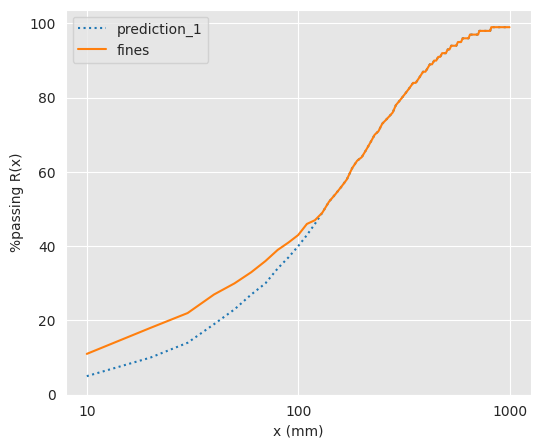

In [14]:
p = []

for tamiz in x:
    if tamiz <= test_fines.iloc[0,-6]:
                n = test_fines.iloc[0,-1]

    elif tamiz > test_fines.iloc[0,-6]:
        n = blast.iloc[0, -2]
    
    pp = round(100 * (1 - math.exp(-0.693 * (tamiz/test_fines.iloc[0, -6])**n)))

    p.append(pp)

sns.set_style("darkgrid", {"axes.facecolor": ".9"})

fig, ax = plt.subplots(figsize = (6,5))

ax.plot(x,Px, label = 'prediction_1', ls = ':')
ax.plot(x,p , label = 'fines')

plt.yticks(np.arange(0,120,step=20))

plt.xscale("log")
ax.xaxis.set_major_formatter(ScalarFormatter())

ax.set_xlabel('x (mm)')
ax.set_ylabel('%passing R(x)')

ax.legend()
plt.show()

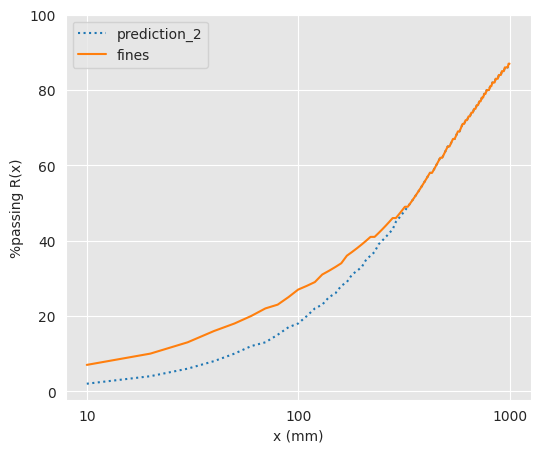

In [15]:
p1 = []

for tamiz in x:
    if tamiz <= test_fines.iloc[1,-6]:
                n = test_fines.iloc[1,-1]

    elif tamiz > test_fines.iloc[1,-6]:
        n = blast.iloc[1, -2]
    
    pp1 = round(100 * (1 - math.exp(-0.693 * (tamiz/test_fines.iloc[1, -6])**n)))

    p1.append(pp1)

sns.set_style("darkgrid", {"axes.facecolor": ".9"})

fig, ax = plt.subplots(figsize = (6,5))

ax.plot(x,Px1, label = 'prediction_2', ls = ':')
ax.plot(x,p1 , label = 'fines')

plt.yticks(np.arange(0,120,step=20))

plt.xscale("log")
ax.xaxis.set_major_formatter(ScalarFormatter())

ax.set_xlabel('x (mm)')
ax.set_ylabel('%passing R(x)')

ax.legend()
plt.show()

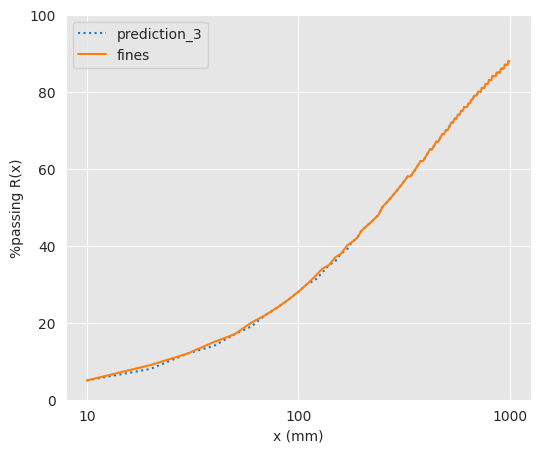

In [16]:
p2 = []

for tamiz in x:
    if tamiz <= test_fines.iloc[2,-6]:
                n = test_fines.iloc[2,-1]

    elif tamiz > test_fines.iloc[2,-6]:
        n = blast.iloc[2, -2]
    
    pp2 = round(100 * (1 - math.exp(-0.693 * (tamiz/test_fines.iloc[2, -6])**n)))

    p2.append(pp2)

sns.set_style("darkgrid", {"axes.facecolor": ".9"})

fig, ax = plt.subplots(figsize = (6,5))

ax.plot(x,Px2, label = 'prediction_3', ls = ':')
ax.plot(x,p2 , label = 'fines')

plt.yticks(np.arange(0,120,step=20))

plt.xscale("log")
ax.xaxis.set_major_formatter(ScalarFormatter())

ax.set_xlabel('x (mm)')
ax.set_ylabel('%passing R(x)')

ax.legend()
plt.show()